In [98]:
import pandas as pd
import numpy as np

In [ ]:
# packages to process the message text
!pip3 install texthero
!pip3 install sweetviz
!pip install -U spacy

import texthero as hero
import sweetviz as sv

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [78]:
chat_df = pd.read_csv('chat_df.csv',lineterminator='\n') 
chat_df.head()

,Unnamed: 0,video_url,timestamp,time_in_seconds,author_id,author_name,author_bio,messages
0,0,https://www.twitch.tv/videos/1619944979,1665353968134000,34.434,536714910,Mar0n1_,NaN,yo first
1,1,https://www.twitch.tv/videos/1619944979,1665353970195000,36.495,39378978,Azkii,"Hello, I am Azkii. Proud member of the Toad Sq...",Have good steam!
2,2,https://www.twitch.tv/videos/1619944979,1665353976374000,42.674,821199354,itzBaMofficial,I play Valorant at the moment,hi
3,3,https://www.twitch.tv/videos/1619944979,1665353978426000,44.726,519136869,youngmoneybandz,hey nerd,yoooo
4,4,https://www.twitch.tv/videos/1619944979,1665353978792000,45.092,477382692,shanenobi,NaN,!crosshair


In [ ]:
#chat_df['video_id'] = chat_df['video_url'].str.strip().str[-10:]

In [79]:
# Well, you can even click on the url. That's neat.
print(chat_df.shape)
chat_df.groupby('video_url')['messages'].count().describe()

(226207, 8)


count       91.000000
mean      2485.780220
std       4476.282599
min          1.000000
25%        135.500000
50%        988.000000
75%       1970.500000
max      20000.000000
Name: messages, dtype: float64

In [80]:
# text preprocessing
from texthero import preprocessing

# create a custom pipeline to preprocess the raw text
custom_pipeline = [preprocessing.fillna
                   , preprocessing.lowercase
                   , preprocessing.remove_digits
                   , preprocessing.remove_punctuation
                   , preprocessing.remove_diacritics
                   , preprocessing.remove_stopwords]

chat_df['clean_messages']= hero.clean(chat_df['messages'], pipeline = custom_pipeline)

In [146]:
# Custom STOPWORDS removal -- Need to think about this.Could use the cloud as below 
from texthero import stopwords
default_stopwords = stopwords.DEFAULT
custom_stopwords = default_stopwords.union(set(['yo','play',"twitch","make", "use", "thank", "content", "good", "use",
                                                "think", "need", "harrisheller", "like", "stream",
                                               "kekw","catjam","tim","timthetatman","tatkevinh",
                                               "wipz","docspin","pog","tatlove","lol","lul","omegalul",
                                               "biblethump","clap","tathypers","pepeja","kappa","tattopd","ppsmoke",
                                               "pepelaugh","gopackgo","gachihyper","tatkevinh", "wipz",
                                               "pausechamp","yep","lmao","jack","lulw","monkaw","kreygasm",
                                               "pepega","peped","foxsalt","pogchamp","xqcn","get","back",
                                               "tattuff","tatfat","tatpumpkin","lmao","sadge","sippy",
                                               "pogu","poggers","consolecd","widepeepohappy","pogu","tategg2",
                                               "modcheck","timmy","tathmm","tats","got","com","babyrage",
                                               "xqcp","tatw","pokiw","know", "thats","pepocd","tatafk",
                                               "4weird","tatkkevin", "tatblanket","tatglam","tategg1","wutface",
                                               "blobdance", "kapp","tatbruh","kappapride","facebaby","xqc",
                                               "xqcm","bora","hyperclap","tatlit","5head","gachibass", "go", "ur",
                                                "yes","going","would","im","oh","dez","taty","tk","u","sg", "dont",
                                                "hey","hf","look","anita","anitaheart","leeper","anitahey",
                                                "anitadab","anitadoubt","anitahands", "anitalul","anitapog","anitasword",
                                                "anitaprime","anitafeels","residentsleeper","anitapride","anital",
                                                "anitabiscuit", "thing","widepeeposad","anitahype","among", "lesbianpride",
                                                "heyguys","seemsgood","notlikethis","hi","also","much","yeah",'http'
                                               ])) ## Add as per requirement

# data = hero.remove_stopwords(data, default_stopwords)
chat_df['clean_messages_custom'] = hero.remove_stopwords(chat_df['clean_messages'], custom_stopwords)

In [147]:
chat_df[['messages','clean_messages','clean_messages_custom']].head()

,messages,clean_messages,clean_messages_custom
0,yo first,yo first,first
1,Have good steam!,good steam,steam
2,hi,hi,
3,yoooo,yoooo,yoooo
4,!crosshair,crosshair,crosshair


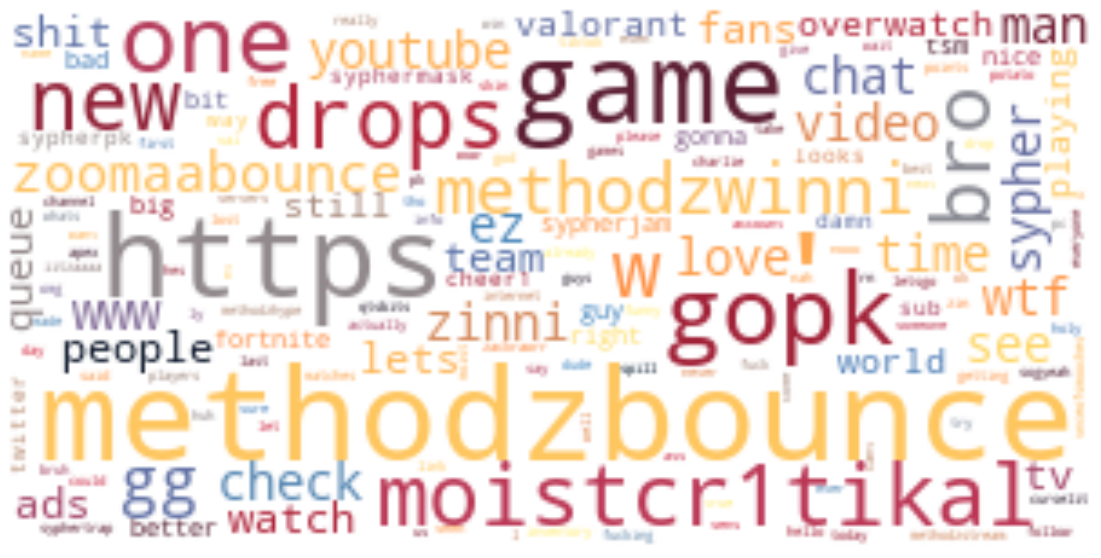

In [148]:
# wordcloud. Well this is not so helpful
hero.visualization.wordcloud(chat_df['clean_messages_custom'], font_path = None, width = 300, height = 150, max_words=200, 
                             mask=None, contour_width=0, 
                             contour_color='PAPAYAWHIP', background_color='WHITE', 
                             relative_scaling='auto', colormap=None, return_figure=False)

### Run LDA on concatenated chat files, video as document, use the topic distribution as features, check out the correlation. 

In [149]:
chat_df.isnull().sum()

Unnamed: 0                    0
video_url                     0
timestamp                     0
time_in_seconds               0
author_id                     0
author_name                   0
author_bio               127762
messages                      1
clean_messages                0
clean_messages_custom         0
dtype: int64

In [152]:
chat_by_vid_df = chat_df.groupby(['video_url'], as_index = False).agg({'author_id': 'count','clean_messages_custom': ' '.join})
chat_by_vid_df.head()

,video_url,author_id,clean_messages_custom
0,https://www.twitch.tv/videos/1013713136,1,und das heisst
1,https://www.twitch.tv/videos/1573420701,15,fridayeu live streaming overwatch retired ...
2,https://www.twitch.tv/videos/1575346830,24,fridayeu live streaming fortnite retired f...
3,https://www.twitch.tv/videos/1577479493,10,fridayeu live streaming fortnite fortnite ...
4,https://www.twitch.tv/videos/1578211985,68,fridayeu live streaming fortnite ex fortni...


In [153]:
# Try LDA first?
import gensim

# Tokenize
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(chat_by_vid_df['clean_messages_custom']))

print(data_words[:5])

[['und', 'das', 'heisst'], ['fridayeu', 'live', 'streaming', 'overwatch', 'retired', 'overwatch', 'pro', 'vibin', 'yooo', 'apex', 'zak', 'overwatch', 'cross', 'platform', 'psn', 'account', 'send', 'snap', 'nahh', 'new', 'ps', 'sym', 'enjoying', 'consider', 'hitting', 'follow', 'button', 'yooo', 'akz', 'deactivate', 'primary', 'ps', 'nahhh', 'overwatch', 'activated', 'primary', 'ps', 'snm', 'follow', 'twitter', 'fridayeu', 'jump', 'mins', 'akz'], ['fridayeu', 'live', 'streaming', 'fortnite', 'retired', 'fortnite', 'pro', 'vibin', 'corgo', 'corgo', 'corgo', 'corgo', 'corgo', 'corgo', 'corgo', 'corgo', 'corgo', 'corgo', 'corgo', 'corgo', 'corgo', 'corgo', 'corgo', 'corgo', 'corgo', 'corgo', 'corgo', 'corgo', 'toch', 'cheered', 'bits', 'cutie', 'ellejjlove', 'alright', 'havin', 'summer', 'traveling', 'drinking', 'concerts', 'beach', 'parties', 'enjoying', 'consider', 'hitting', 'follow', 'button', 'shat', 'omds', 'knocked', 'fuck', 'shit', 'gameplay', 'take', 'shit', 'airwaves', 'classic',

In [ ]:
import spacy

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append(" ".join([token.lemma_ if token.lemma_ not in ['-PRON-'] else '' for token in doc if token.pos_ in allowed_postags]))
    return texts_out

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)

nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Do lemmatization keeping only Noun, Adjective, Verb, Adverb
data_lemmatized = lemmatization(data_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:5])

In [155]:
# Sklearn
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from pprint import pprint

# Plotting tools
!pip install -U pyLDAvis
import pyLDAvis
import pyLDAvis.sklearn
import matplotlib.pyplot as plt
%matplotlib inline

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [156]:
# Word-Document Matrix
# This converts a collection of text documents to a matrix of token counts. 
# A document-term matrix or term-document matrix is a mathematical matrix that describes the frequency of terms that occur in a collection of documents. 
# In a document-term matrix, rows correspond to documents in the collection and columns correspond to terms. 

vectorizer = CountVectorizer(analyzer='word',       
                             min_df=10,                        # minimum number occurences of a word required
                             stop_words='english',             # remove stop words
                             lowercase=True,                   # convert all words to lowercase
                             token_pattern='[a-zA-Z0-9]{3,}')  # num of characters > 3
                            

data_vectorized = vectorizer.fit_transform(data_lemmatized)

In [157]:
# Build LDA model with Sklearn

lda_model = LatentDirichletAllocation(n_components=15,               # Number of topics
                                      max_iter=10,                   # Max learning iterations
                                      learning_method='online',   
                                      random_state=100,              # Random state
                                      batch_size=128)                # n docs in each learning iter
                                            
                                      
lda_output = lda_model.fit_transform(data_vectorized)

print(lda_model)  # Model attributes

LatentDirichletAllocation(learning_method='online', n_components=15,
                          random_state=100)


In [158]:
#Evaluate model quality

# Log Likelihood: Higher the better
print("Log Likelihood: ", lda_model.score(data_vectorized))

# Perplexity: Lower the better. Perplexity = exp((-1) * log-likelihood per word)
print("Perplexity: ", lda_model.perplexity(data_vectorized))

Log Likelihood:  -1575537.239482735
Perplexity:  570.1853457531779


In [160]:
# Grid Search for Best LDA Model
# Grid search is a tuning technique that attempts to compute the optimum values of hyperparameters. 
# It is an exhaustive search that is performed on a the specific parameter values of a model. The model is also known as an estimator.
# This is computationally expensive and usually takes time... 

from sklearn.model_selection import GridSearchCV

# Define Search Param
params = {'n_components': [5, 10, 15], 'learning_decay': [.5, .7, .9]}

# Model
lda = LatentDirichletAllocation()

# Grid Search
model = GridSearchCV(lda, param_grid=params)

# Perform Grid Search
model.fit(data_vectorized)

GridSearchCV(estimator=LatentDirichletAllocation(),
             param_grid={'learning_decay': [0.5, 0.7, 0.9],
                         'n_components': [5, 10, 15]})

In [161]:
# Best Model
best_lda_model = model.best_estimator_

# Model Parameters
print("Best Model's Params: ", model.best_params_)

# Log Likelihood Score
print("Best Log Likelihood Score: ", model.best_score_)

# Perplexity
print("Model Perplexity: ", best_lda_model.perplexity(data_vectorized))

Best Model's Params:  {'learning_decay': 0.9, 'n_components': 5}
Best Log Likelihood Score:  -348625.49434171023
Model Perplexity:  566.4309974843857


In [162]:
# Reflections:
# how important and how frequent certain words are in the corpus - what themes/etc. may emerge. 
# Show top n keywords for each topic

def show_topics(vectorizer=vectorizer, lda_model=best_lda_model, n_words=20):
    keywords = np.array(vectorizer.get_feature_names())
    topic_keywords = []
    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords

topic_keywords = show_topics(vectorizer=vectorizer, lda_model=best_lda_model, n_words=10)        

# Topic - Keywords Dataframe
df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]
df_topic_keywords

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9
Topic 0,fan,world,mean,earth,long,number,let,sub,gifting,https
Topic 1,drop,https,check,tsm,game,match,info,inventory,team,www
Topic 2,https,bit,valorant,let,follow,channel,time,tiktok,game,youtube
Topic 3,video,sypher,new,guy,watch,syphermask,say,sypherpk,curselit,man
Topic 4,game,queue,overwatch,server,new,play,look,people,time,player


In [164]:
# concatenation reference: https://pandas.pydata.org/pandas-docs/stable/user_guide/merging.html
doc_topic_dist = best_lda_model.transform(data_vectorized)
topic_df = pd.DataFrame(doc_topic_dist,
                        columns = ['topic0','topic2','topic3','topic4','topic5'])
chat_topic_df = pd.concat([chat_by_vid_df, topic_df.reindex(chat_by_vid_df.index)], axis=1)
chat_topic_df.head()

,video_url,author_id,clean_messages_custom,topic0,topic2,topic3,topic4,topic5
0,https://www.twitch.tv/videos/1013713136,1,und das heisst,0.200000,0.200000,0.200000,0.200000,0.200000
1,https://www.twitch.tv/videos/1573420701,15,fridayeu live streaming overwatch retired ...,0.010190,0.168419,0.200450,0.010134,0.610808
2,https://www.twitch.tv/videos/1575346830,24,fridayeu live streaming fortnite retired f...,0.005551,0.069553,0.764172,0.005552,0.155172
3,https://www.twitch.tv/videos/1577479493,10,fridayeu live streaming fortnite fortnite ...,0.008784,0.008916,0.232332,0.008947,0.741020
4,https://www.twitch.tv/videos/1578211985,68,fridayeu live streaming fortnite ex fortni...,0.002754,0.002770,0.284355,0.436424,0.273697


In [165]:
chat_topic_df['video_id'] = chat_topic_df['video_url'].str.strip().str[-10:]

In [137]:
video_df = pd.read_csv('video_df_merge.csv')
video_df.columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1655 entries, 0 to 1654
Data columns (total 24 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Unnamed: 0                     1655 non-null   object 
 1   id                             1655 non-null   object 
 2   stream_id                      1655 non-null   object 
 3   user_id                        1655 non-null   object 
 4   user_login                     1635 non-null   object 
 5   user_name                      1635 non-null   object 
 6   title                          1635 non-null   object 
 7   description                    19 non-null     object 
 8   created_at                     1635 non-null   object 
 9   published_at                   1635 non-null   object 
 10  url                            1635 non-null   object 
 11  thumbnail_url                  1623 non-null   object 
 12  viewable                       1635 non-null   o

In [166]:
data_vid_df = pd.merge(chat_topic_df, video_df, how="left", left_on='video_id',right_on = 'id')
data_vid_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100 entries, 0 to 99
Data columns (total 33 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   video_url                      100 non-null    object 
 1   author_id                      100 non-null    int64  
 2   clean_messages_custom          100 non-null    object 
 3   topic0                         100 non-null    float64
 4   topic2                         100 non-null    float64
 5   topic3                         100 non-null    float64
 6   topic4                         100 non-null    float64
 7   topic5                         100 non-null    float64
 8   video_id                       100 non-null    object 
 9   Unnamed: 0                     100 non-null    object 
 10  id                             100 non-null    object 
 11  stream_id                      100 non-null    object 
 12  user_id                        100 non-null    obje

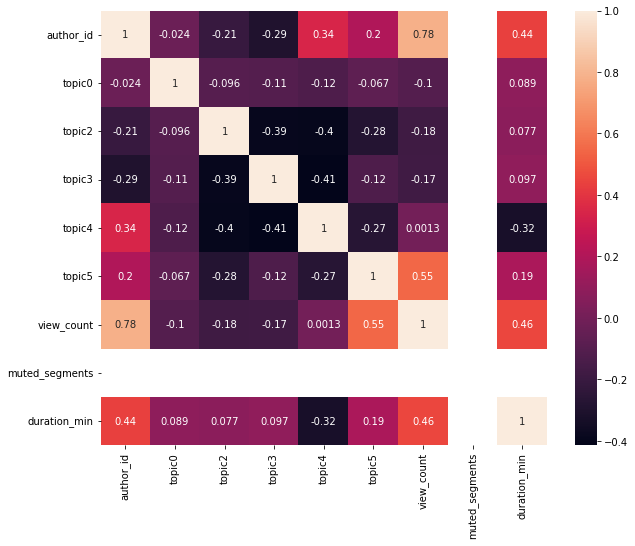

In [167]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10,8))   
sns.heatmap(data_vid_df.corr(), annot=True)

In [163]:
data_vid_df.describe()

,author_id,topic0,topic2,topic3,topic4,topic5,view_count,muted_segments,duration_min
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,0.0,100.000000
mean,4062.070000,0.217424,0.261181,0.237749,0.126578,0.157068,39792.550000,NaN,107.637333
std,6602.437281,0.368353,0.353604,0.332890,0.314808,0.329943,99192.004963,NaN,79.505816
min,1.000000,0.000007,0.000007,0.000039,0.000007,0.000007,0.000000,NaN,0.333333
25%,269.250000,0.000061,0.000200,0.008052,0.000148,0.000054,48.250000,NaN,30.395833
50%,1175.500000,0.001548,0.020815,0.085905,0.000865,0.000276,623.000000,NaN,91.641667
75%,3567.750000,0.363732,0.553989,0.258777,0.013731,0.030604,14959.250000,NaN,182.933333
max,20000.000000,0.999843,0.999822,0.999974,0.999812,0.992717,474421.000000,NaN,238.733333


### 